Temperature of Gas : 400.0  residence time : 0.009925987742498206
Temperature of Gas : 410.0  residence time : 0.009683889703908287
Temperature of Gas : 420.0  residence time : 0.00945331964850524
Temperature of Gas : 430.0  residence time : 0.009233473037296495
Temperature of Gas : 440.0  residence time : 0.009023618358509095
Temperature of Gas : 450.0  residence time : 0.008823088974510326
Temperature of Gas : 460.0  residence time : 0.008631276021833627
Temperature of Gas : 470.0  residence time : 0.008447622205485448
Temperature of Gas : 480.0  residence time : 0.008271616354954658
Temperature of Gas : 490.0  residence time : 0.00810278863078118
Temperature of Gas : 500.0  residence time : 0.00794070628814599
Temperature of Gas : 510.0  residence time : 0.007784969918520787
Temperature of Gas : 520.0  residence time : 0.007635210102553256
Temperature of Gas : 530.0  residence time : 0.00749108441763279
Temperature of Gas : 540.0  residence time : 0.007352274752309283
Temperature of

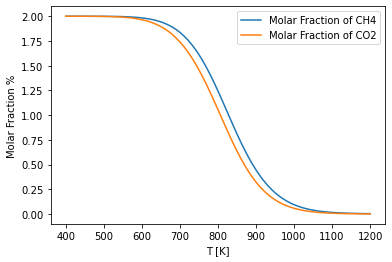

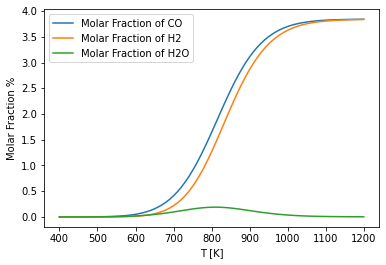

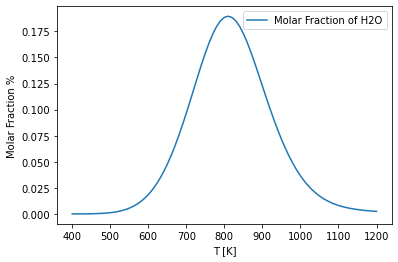

In [1]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt

# unit conversion factors to SI
cm = 0.01
minute = 60.0

# Set the initial value of flow
t0 = 298.15
pressure = 0.986923267* ct.one_atm
Q = 4e3 * cm**3 / minute

# dimension of reactor
length = 2.7 * cm  # Catalyst bed length
dint = 1 *cm
area = np.pi * dint**2 /4  # Catalyst bed area
cat_area_per_vol = 9.85e6  # Catalyst particle surface area per unit volume
porosity = 0.42  # Catalyst bed porosity

#################################################
# input file containing the surface reaction mechanism
cti_file = 'Ni_surf_mech.cti'
composition = 'CH4:1, CO2:1, N2:48'
# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 101

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')
gas.TPX = t0, ct.one_atm, composition # This condition is used to get the total mass flow rate
# Set the mass flow rate before simulating
mass_flow_rate = Q * gas.density

surf = ct.Interface(cti_file,'Ni_surf', [gas])

rlen = length/(NReactors-1)
rvol = area * rlen * porosity
# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

def solve(gas,t):
    # Set the temperature and pressure for gas
    # t is different from t0
    gas.TPX = t, pressure, composition
    surf.TP = t, pressure
    TDY = gas.TDY
    cov = surf.coverages

    # create a new reactor
    gas.TDY = TDY
    r = ct.IdealGasReactor(gas, energy='off')
    r.volume = rvol

    upstream = ct.Reservoir(gas, name='upstream')
    downstream = ct.Reservoir(gas, name='downstream')
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

    v = ct.PressureController(r, downstream, master=m, K=1e-5)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 20
    sim.rtol = 1.0e-9
    sim.atol = 1.0e-21

    # define time, space, and other information vectors
    z2 = (np.arange(NReactors)) * rlen * 1e3

    t_r2 = np.zeros_like(z2)  # residence time in each reactor

    t2 = np.zeros_like(z2)
    states2 = ct.SolutionArray(gas)

    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY = r.thermo.TDY
        upstream.syncState()
        sim.reinitialize()

        sim.advance_to_steady_state()
        dist = n * rlen * 1.0e3  # distance in mm

        t_r2[n] = r.mass / mass_flow_rate  # residence time in this reactor
        t2[n] = np.sum(t_r2)
        states2.append(gas.state)
    print('Temperature of Gas :', t,' residence time :', t2[-1])
    MolFrac_CH4 = states2('CH4').X
    MolFrac_CO2 = states2('CO2').X
    MolFrac_CO  = states2('CO').X
    MolFrac_H2  = states2('H2').X
    MolFrac_H2O = states2('H2O').X
    kq = np.zeros(5)
    kq[0] = MolFrac_CH4[-1]*100
    kq[1] = MolFrac_CO2[-1]*100
    kq[2] = MolFrac_CO[-1]*100
    kq[3] = MolFrac_H2[-1]*100
    kq[4] = MolFrac_H2O[-1]*100
    return kq

n = 81
Tem = np.linspace(400,1200,n)
CH4_Mol_Fr = np.zeros_like(Tem)
CO2_Mol_Fr = np.zeros_like(Tem)
CO_Mol_Fr = np.zeros_like(Tem)
H2_Mol_Fr = np.zeros_like(Tem)
H2O_Mol_Fr = np.zeros_like(Tem)
for i in range(n):
    kq = solve(gas,Tem[i])
    CH4_Mol_Fr[i] = kq[0]
    CO2_Mol_Fr[i] = kq[1]
    CO_Mol_Fr[i] = kq[2]
    H2_Mol_Fr[i]= kq[3]
    H2O_Mol_Fr[i]= kq[4]

import matplotlib.pyplot as plt
plt.figure()
plt.plot(Tem, CH4_Mol_Fr, label = 'Molar Fraction of CH4')
plt.plot(Tem, CO2_Mol_Fr, label = 'Molar Fraction of CO2')
plt.xlabel('T [K]')
plt.ylabel('Molar Fraction %')
plt.legend(loc=0)
# plt.show()

plt.figure()
plt.plot(Tem, CO_Mol_Fr, label = 'Molar Fraction of CO')
plt.plot(Tem, H2_Mol_Fr, label = 'Molar Fraction of H2')
plt.plot(Tem, H2O_Mol_Fr, label = 'Molar Fraction of H2O')
plt.xlabel('T [K]')
plt.ylabel('Molar Fraction %')
plt.legend(loc=0)
# plt.show()

plt.figure()
plt.plot(Tem, H2O_Mol_Fr, label = 'Molar Fraction of H2O')
plt.xlabel('T [K]')
plt.ylabel('Molar Fraction %')
plt.legend(loc=0)
plt.show()
